In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kdd-cup-1999-data/kddcup.data.gz
/kaggle/input/kdd-cup-1999-data/training_attack_types
/kaggle/input/kdd-cup-1999-data/kddcup.data.corrected
/kaggle/input/kdd-cup-1999-data/kddcup.newtestdata_10_percent_unlabeled.gz
/kaggle/input/kdd-cup-1999-data/kddcup.testdata.unlabeled.gz
/kaggle/input/kdd-cup-1999-data/corrected.gz
/kaggle/input/kdd-cup-1999-data/kddcup.data_10_percent.gz
/kaggle/input/kdd-cup-1999-data/kddcup.names
/kaggle/input/kdd-cup-1999-data/kddcup.data_10_percent_corrected
/kaggle/input/kdd-cup-1999-data/typo-correction.txt
/kaggle/input/kdd-cup-1999-data/kddcup.testdata.unlabeled_10_percent.gz
/kaggle/input/kdd-cup-1999-data/kddcup.data/kddcup.data
/kaggle/input/kdd-cup-1999-data/kddcup.testdata.unlabeled/kddcup.testdata.unlabeled
/kaggle/input/kdd-cup-1999-data/corrected/corrected
/kaggle/input/kdd-cup-1999-data/kddcup.testdata.unlabeled_10_percent/kddcup.testdata.unlabeled_10_percent
/kaggle/input/kdd-cup-1999-data/kddcup.newtestdata_10_percent_unlabeled/kd

Load Data

In [48]:
FOLDER_PATH='/kaggle/input/kdd-cup-1999-data/'
import os
os.listdir(FOLDER_PATH)[:3]

['kddcup.data.gz', 'kddcup.data', 'kddcup.testdata.unlabeled']

In [49]:
#install package
!pip install category_encoders
!pip install xgboost

In [50]:
#Necessary Libraries 
import numpy as np

import gc; gc.enable() #Enable garbage for the notebook

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time


import warnings

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox,norm,lognorm
from sklearn.metrics import classification_report,accuracy_score,f1_score
from typing import Tuple,List
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
warnings.filterwarnings("ignore")

In [51]:
def load_data():
    
    f=open(FOLDER_PATH +"kddcup.names",'r')
    data=f.readlines()[1:]

    column_names=[]
    for line in data:
        column_names.append(line.split(':')[0])

    column_names.append('target')
    f.close()

    f=open(FOLDER_PATH + "training_attack_types","r")
    data=f.readlines()[:-1]

    attack_type_mapping={'normal':'normal'}
    for line in data:
        k,v=line.split()
        attack_type_mapping[k]=v

    f.close()

    temp=pd.read_csv(FOLDER_PATH + "kddcup.data_10_percent.gz",names=column_names)
    temp['Attack Type']=temp.target.apply(lambda r: attack_type_mapping[r[:-1]])
    
    return temp

EDA

In [52]:
df=load_data()
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,Attack Type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compromised              494021 non-null  int64  
 13 

In [54]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [55]:
#liệt kê định dạng của các feature
num_vars=df.select_dtypes(exclude=['object']).columns.to_list()
cate_vars=df.select_dtypes(include=['object']).columns.to_list()
cate_vars.remove('Attack Type')
disc_vars=['land','logged_in','root_shell','su_attempted','is_host_login','is_guest_login']
conti_vars=[i for i in num_vars if i not in disc_vars]
print(f'categorical variables:{cate_vars}')
print(f'continuous variables:{conti_vars}')
print(f'discrete variables:{disc_vars}')

categorical variables:['protocol_type', 'service', 'flag', 'target']
continuous variables:['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
discrete variables:['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']


phân phối output


<Axes: xlabel='Attack Type', ylabel='count'>

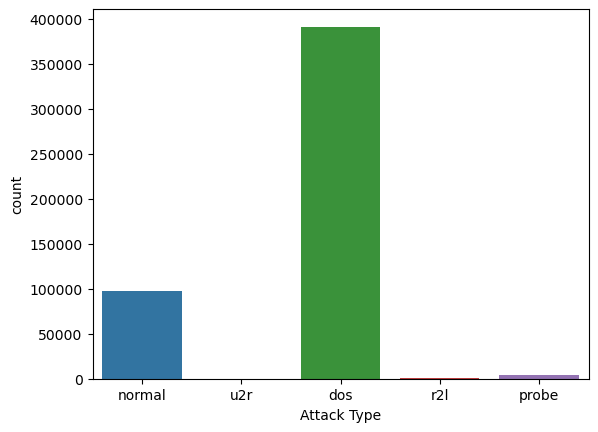

In [56]:
sns.countplot(x=df['Attack Type'])


các giá trị u2r,r2l,probe chiếm số lượng rất nhỏ trong trường output( không đáng kể) -> nhóm các giá trị này chung thành 1 giá trị để tránh làm giảm hiệu suất mô hình

In [57]:
df['Attack Type'].replace({'u2r':'other','r2l':'other','probe':'other'},inplace=True)

In [69]:
df['Attack Type'].unique()


array(['normal', 'other', 'dos'], dtype=object)

Phân Phối biến liên tục

KeyboardInterrupt: 

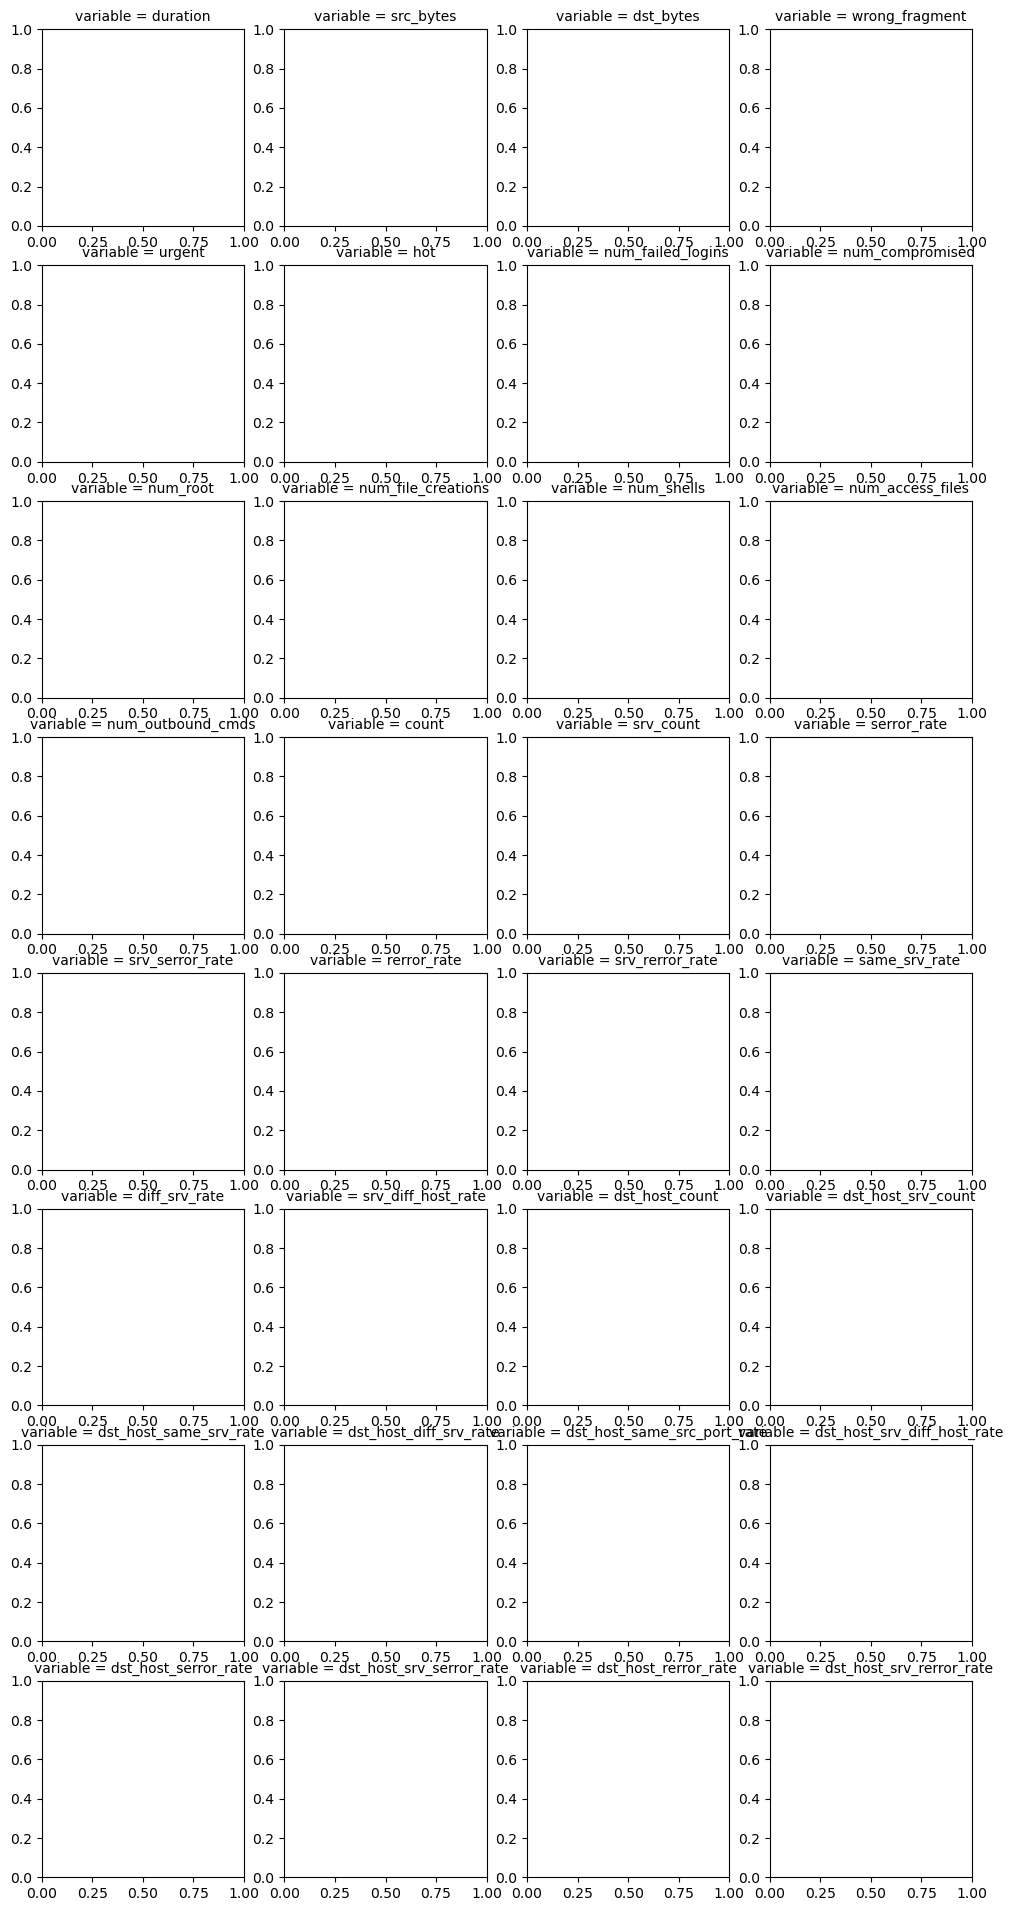

In [77]:
f=pd.melt(df,value_vars=conti_vars)
graph=sns.FacetGrid(f,col='variable',col_wrap=4,sharex=False,sharey=False)
graph.map(sns.distplot,'value')

phân phối biến rời rạc

In [ ]:
f1=pd.melt(df,value_vars=disc_vars)
graph=sns.FacetGrid(f1,col='variable',col_wrap=4,sharex=False,sharey=False)
graph.map(sns.countplot,'value')

In [ ]:
a=list()
for i in disc_vars:
    a.append(df[i].nunique())
a    

phân bố biến category

In [ ]:
## Plot categories attributes
def plot_dist_categories(col, ax):
    df[col].value_counts().plot(kind='bar',facecolor='g', ax=ax)
    ax.set_xlabel('{}'.format(col), fontsize=18)
    ax.set_title("Distribution of {} feature".format(col), fontsize= 18)
    plt.xticks(rotation=45)
    return ax

fig, ax = plt.subplots(2,2, figsize = (30,30))
fig.tight_layout(h_pad=15, w_pad=10, rect=[0, 0.08, 1, 0.93])

k = 0
for i in range(2):
    for j in range(2):
        plot_dist_categories(cate_vars[k], ax[i][j])
        k += 1

plt.show()
                 
        
                 

Note: trường 'Land' chỉ chứa 1 giá trị->trường này k giúp ích trong việc phân loại dữ liệu của mình -> xóa trường này để giảm bớt độ phức tạp trong tính toán của model

Tương quan của các trường dữ liệu liên tục vs output

In [ ]:
def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    x=plt.xticks(rotation=90)
f2=pd.melt(df,id_vars='Attack Type',value_vars=conti_vars)
graph=sns.FacetGrid(f2,col='variable',col_wrap=4,sharex=False,sharey=False)
graph.map(boxplot,'Attack Type','value')
    

In [ ]:
def countplot(x,y,**kwargs):
    sns.countplot(x=x,hue=y)
    x=plt.xticks(rotation=90)
f3=pd.melt(df,id_vars='Attack Type',value_vars=cate_vars+disc_vars)
graph=sns.FacetGrid(f3,col='variable',col_wrap=4,sharex=False,sharey=False)
graph.map(countplot,'value','Attack Type')
      

tương quan giữa các trường dữ liệu Numerical

In [ ]:
plt.figure(figsize=(10,10))
cmap=sns.cubehelix_palette(light=0.95,as_cmap=True)
sns.heatmap(abs(df.drop(columns=['is_host_login','num_outbound_cmds']).corr(method='pearson')),vmin=0,vmax=1,square=True,cmap=cmap)
plt.show()

1 số trường có correlation vs nhau rất cao->điều này dẫn đến nhiều khả năng thông tin mà các trường này mang lại khá tương tự nhau dẫn đến việc nếu có 2 trường có correlation vs nhau cao thì ta có thể drop 1 trong 2 trường để biến dữ liệu mình có về đơn giản hơn.

các trường có corr cao:
num_root vs num_compromised
srv_serror_rate vs serror_rate
srv_count vs count
srv_rerror_rate vs rerror_rate
dst_host_same_srv_rate vs dst_host_srv_count
dst_host_srv_serror_rate vs dst_host_serror_rate
dst_host_srv_rerror_rate vs dst_host_rerror_rate
dst_host_same_srv_rate vs same_srv_rate
dst_host_srv_count vs same_srv_rate
dst_host_same_src_port_rate vs srv_count
dst_host_serror_rate vs serror_rate
dst_host_srv_rerror_rate vs srv_rerror_rate


PreProcessing Data

3.1:Drop các trường chỉ chứa 1 giá trị hoặc 2 giá trị nhưng chênh lệch số lượng sample trong các giá trị là rất lớn

In [70]:
df.drop(columns=['land'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   wrong_fragment               494021 non-null  int64  
 7   urgent                       494021 non-null  int64  
 8   hot                          494021 non-null  int64  
 9   num_failed_logins            494021 non-null  int64  
 10  logged_in                    494021 non-null  int64  
 11  num_compromised              494021 non-null  int64  
 12  root_shell                   494021 non-null  int64  
 13 

3.2 Drop các trường có correlation cao

In [71]:
df.drop(columns=['num_root','srv_serror_rate','srv_rerror_rate','dst_host_srv_serror_rate','dst_host_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','dst_host_same_srv_rate'],inplace=True)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 34 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   wrong_fragment               494021 non-null  int64  
 7   urgent                       494021 non-null  int64  
 8   hot                          494021 non-null  int64  
 9   num_failed_logins            494021 non-null  int64  
 10  logged_in                    494021 non-null  int64  
 11  num_compromised              494021 non-null  int64  
 12  root_shell                   494021 non-null  int64  
 13 

In [73]:
conti_vars=[i for i in df.columns.to_list() if i in conti_vars]
disc_vars=[i for i in df.columns.to_list() if i in disc_vars]


3.3 Xử lý outlier

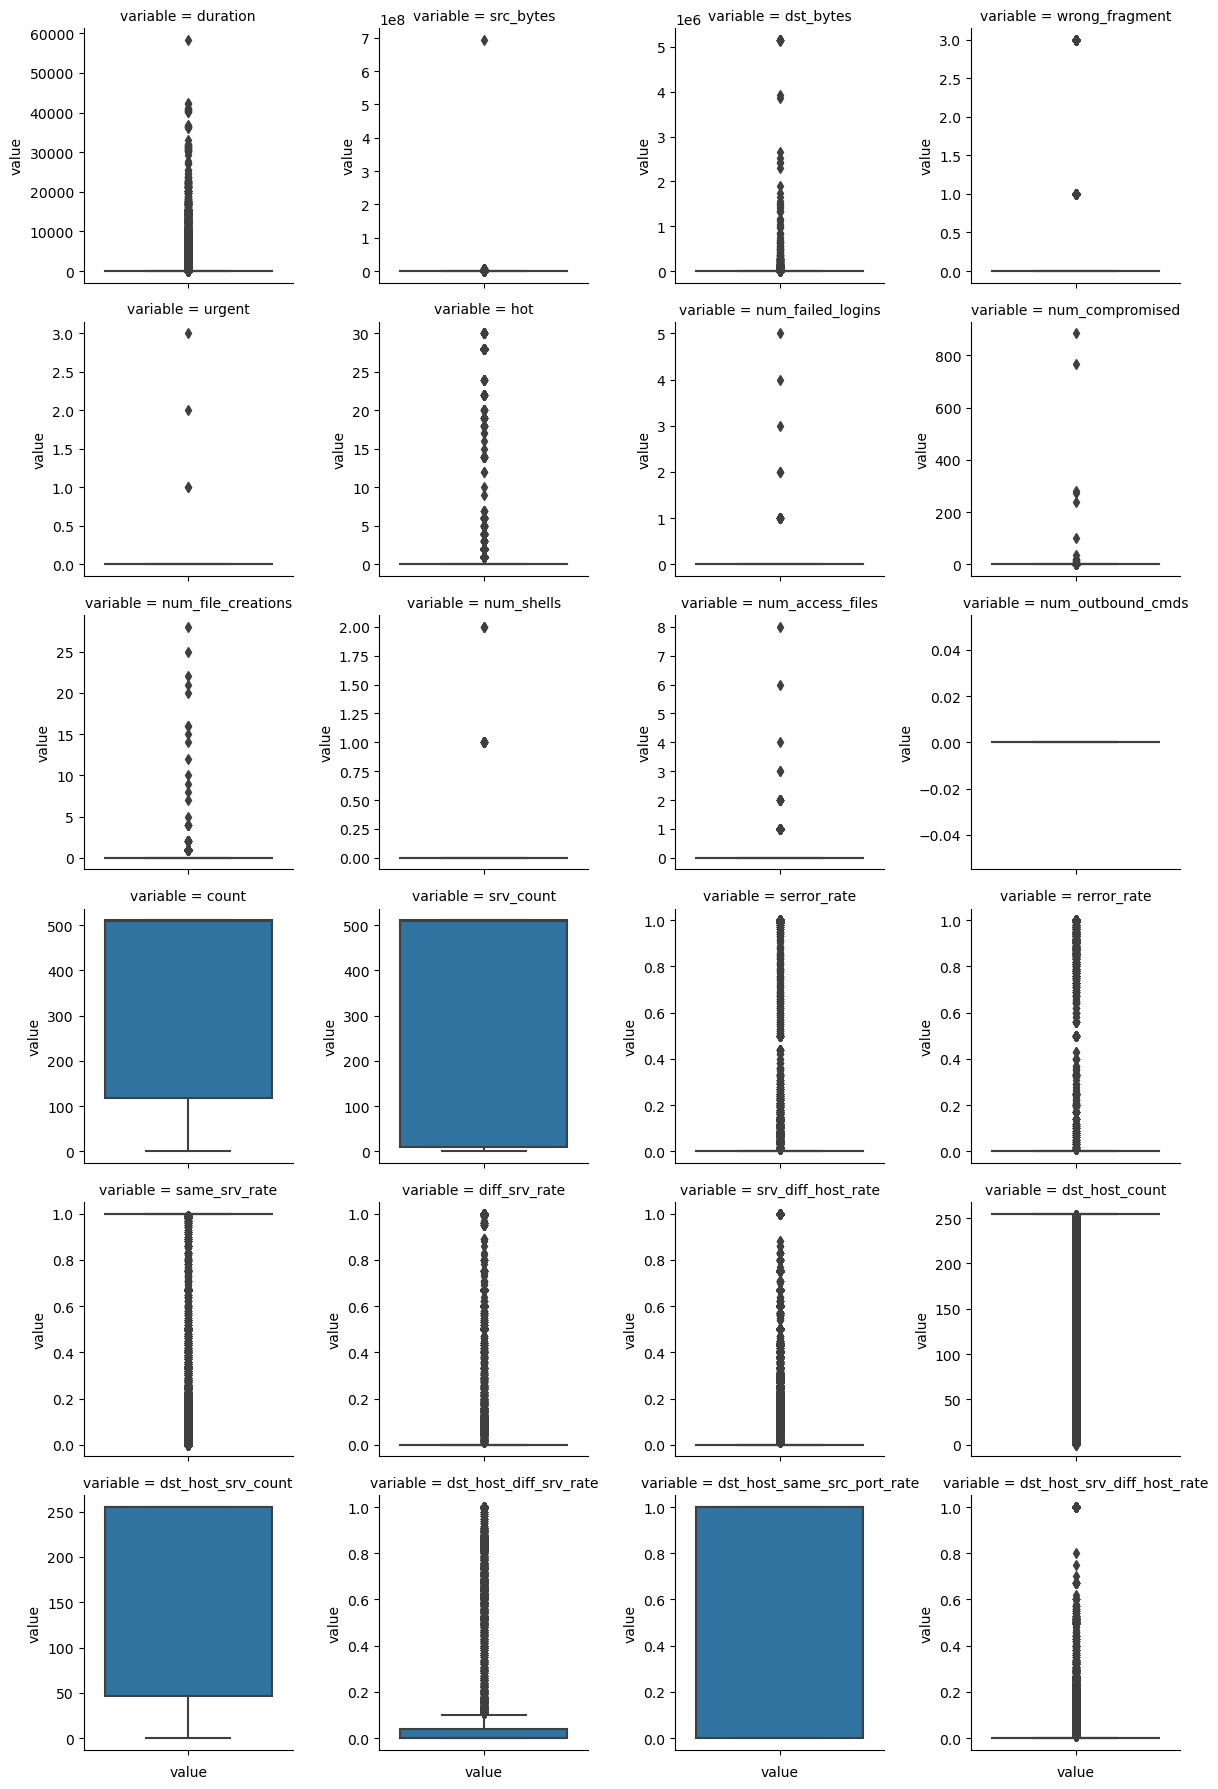

In [125]:
#biểu đồ boxplot xác định outliers continuous variables
def boxplot(y,**kwargs):
    sns.boxplot(y=y)
    x=plt.xticks(rotation=90)
f2=pd.melt(df,value_vars=conti_vars)
graph=sns.FacetGrid(f2,col='variable',col_wrap=4,sharex=False,sharey=False)
graph.map(boxplot,'value')

In [74]:

def find_boxplot_boundaries(
    col: pd.DataFrame, whisker_coeff: float = 1.5
) -> Tuple[float, float]:
    """Findx minimum and maximum in boxplot.

    Args:
        col: a pandas dataframe of input.
        whisker_coeff: whisker coefficient in box plot
    """
    Q1 = col.quantile(0.25).to_numpy()
    Q3 = col.quantile(0.75).to_numpy()
    IQR = Q3 - Q1
    lower = Q1 - whisker_coeff * IQR
    upper = Q3 + whisker_coeff * IQR
    return lower, upper


class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, whisker_coeff: float = 1.5):
        self.whisker = whisker_coeff
        self.lower = None
        self.upper = None

    def fit(self, X: pd.Series):
        self.lower, self.upper = find_boxplot_boundaries(X, self.whisker)
        return self

    def transform(self, X):
        return X.clip(self.lower, self.upper)    


      
    
    

In [75]:
#chia dữ liệu trước khi xử lý
df['target']=df['target'].str.rstrip('.')
target=df['target']
df.drop('target',axis=1,inplace=True)
train,test=train_test_split(df,test_size=0.2,random_state=42)
X_train=train.drop('Attack Type',axis=1)
y_train=train['Attack Type']
X_test=test.drop('Attack Type',axis=1)
y_test=test['Attack Type']

In [76]:
#xử lý outlier với continuous variable
boc=BoxplotOutlierClipper()
X_train[conti_vars]=boc.fit_transform(X_train[conti_vars])
X_test[conti_vars]=boc.transform(X_test[conti_vars])

In [77]:
#xử lý outlier với discrete variable
lower_train=find_boxplot_boundaries(X_train[disc_vars])[0]
upper_train=find_boxplot_boundaries(X_train[disc_vars])[1]
lower_test=find_boxplot_boundaries(X_test[disc_vars])[0]
upper_test=find_boxplot_boundaries(X_test[disc_vars])[1]
k=0
for i in disc_vars:
    X_train[i][(X_train[i] <lower_train[k])|(X_train[i]>upper_train[k])]=np.nan
    X_test[i][(X_test[i] <lower_test[k])|(X_test[i]>upper_test[k])]=np.nan
    k+=1
X_train[disc_vars]=train.groupby('Attack Type')[disc_vars].transform(lambda x:x.fillna(x.mean()))
X_test[disc_vars]=test.groupby('Attack Type')[disc_vars].transform(lambda x:x.fillna(x.mean()))

In [ ]:
#biểu đồ boxplot với continuous variables sau khi xử lý outliers
def boxplot(y,**kwargs):
    sns.boxplot(y=y)
    x=plt.xticks(rotation=90)
f2=pd.melt(X_train,value_vars=conti_vars)
graph=sns.FacetGrid(f2,col='variable',col_wrap=4,sharex=False,sharey=False)
graph.map(boxplot,'value')

In [79]:
#drop các trường chỉ còn lại 1 giá trị sau khi xử lý outlier
only=[]
for i in X_train.columns.to_list():
    if X_train[i].nunique()==1:
      only.append(i)
X_train.drop(columns=only,inplace=True)
X_test.drop(columns=only,inplace=True)

In [80]:
X_train

,protocol_type,service,flag,src_bytes,logged_in,root_shell,su_attempted,is_guest_login,count,srv_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate
133888,icmp,ecr_i,SF,1032,0,0,0,0,511,511,255,0.00,1.00
67704,tcp,private,S0,0,0,0,0,0,220,10,10,0.07,0.00
391027,tcp,private,S0,0,0,0,0,0,295,24,24,0.05,0.00
372089,tcp,http,REJ,0,0,0,0,0,1,1,8,0.00,0.12
460597,tcp,private,REJ,0,0,0,0,0,111,7,7,0.07,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,icmp,ecr_i,SF,1032,0,0,0,0,511,511,255,0.00,1.00
365838,tcp,private,S0,0,0,0,0,0,105,5,8,0.06,0.00
131932,icmp,ecr_i,SF,1032,0,0,0,0,511,511,255,0.00,1.00
146867,udp,other,SF,147,0,0,0,0,1,1,3,0.10,0.84


In [81]:
X_test

,protocol_type,service,flag,src_bytes,logged_in,root_shell,su_attempted,is_guest_login,count,srv_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate
317921,icmp,ecr_i,SF,1032,0,0,0,0,511,511,255,0.00,1.00
171422,icmp,ecr_i,SF,1032,0,0,0,0,511,511,255,0.00,1.00
312181,icmp,ecr_i,SF,1032,0,0,0,0,511,511,255,0.00,1.00
87346,tcp,http,SF,345,1,0,0,0,6,6,255,0.00,0.01
57449,tcp,private,S0,0,0,0,0,0,260,2,2,0.07,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
367818,tcp,private,S0,0,0,0,0,0,128,11,7,0.07,0.00
82157,tcp,http,SF,303,1,0,0,0,15,19,255,0.00,0.07
26246,tcp,http,SF,306,1,0,0,0,10,10,255,0.00,0.00
303821,icmp,ecr_i,SF,1032,0,0,0,0,511,511,255,0.00,1.00


In [82]:
cate_vars.remove('target')

In [83]:
cate_vars

['protocol_type', 'service', 'flag']

3.4 encode các trường categorical

rõ ràng là chúng ta quan tâm xem 1 mạng có bị tấn công hay không hơn là việc nó bị tấn công bởi loại tấn công nào do đó chúng ta encode giá trị 'normal' trong output về 1 (trong ML thường được hiểu là giá trị được chú trọng hơn) và các giá trị còn lại về 0

In [84]:

X_train['label_transform']=train['Attack Type'].map({'normal':1,'dos':0,'other':0})

In [116]:
X_train

,protocol_type,service,flag,src_bytes,logged_in,root_shell,su_attempted,is_guest_login,count,srv_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,label_transform
133888,icmp,ecr_i,SF,1032,0,0,0,0,511,511,255,0.00,1.00,0
67704,tcp,private,S0,0,0,0,0,0,220,10,10,0.07,0.00,0
391027,tcp,private,S0,0,0,0,0,0,295,24,24,0.05,0.00,0
372089,tcp,http,REJ,0,0,0,0,0,1,1,8,0.00,0.12,1
460597,tcp,private,REJ,0,0,0,0,0,111,7,7,0.07,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,icmp,ecr_i,SF,1032,0,0,0,0,511,511,255,0.00,1.00,0
365838,tcp,private,S0,0,0,0,0,0,105,5,8,0.06,0.00,0
131932,icmp,ecr_i,SF,1032,0,0,0,0,511,511,255,0.00,1.00,0
146867,udp,other,SF,147,0,0,0,0,1,1,3,0.10,0.84,1


In [85]:
from category_encoders.target_encoder import TargetEncoder
from category_encoders.james_stein import JamesSteinEncoder
jse=JamesSteinEncoder()
X_train[cate_vars]=jse.fit_transform(X_train[cate_vars],X_train['label_transform'])
X_test[cate_vars]=jse.transform(X_test[cate_vars])

In [118]:
X_test

,protocol_type,service,flag,src_bytes,logged_in,root_shell,su_attempted,is_guest_login,count,srv_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate
317921,0.004439,0.002657,0.223207,1032,0,0,0,0,511,511,255,0.00,1.00
171422,0.004439,0.002657,0.223207,1032,0,0,0,0,511,511,255,0.00,1.00
312181,0.004439,0.002657,0.223207,1032,0,0,0,0,511,511,255,0.00,1.00
87346,0.404179,0.825340,0.223207,345,1,0,0,0,6,6,255,0.00,0.01
57449,0.404179,0.102271,0.001055,0,0,0,0,0,260,2,2,0.07,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
367818,0.404179,0.102271,0.001055,0,0,0,0,0,128,11,7,0.07,0.00
82157,0.404179,0.825340,0.223207,303,1,0,0,0,15,19,255,0.00,0.07
26246,0.404179,0.825340,0.223207,306,1,0,0,0,10,10,255,0.00,0.00
303821,0.004439,0.002657,0.223207,1032,0,0,0,0,511,511,255,0.00,1.00


3.6 Normalization

In [86]:
conti_vars=[i for i in X_train.columns.to_list() if i in conti_vars]
disc_vars=[i for i in X_train.columns.to_list() if i in disc_vars]

In [87]:
disc_vars

['logged_in', 'root_shell', 'su_attempted', 'is_guest_login']

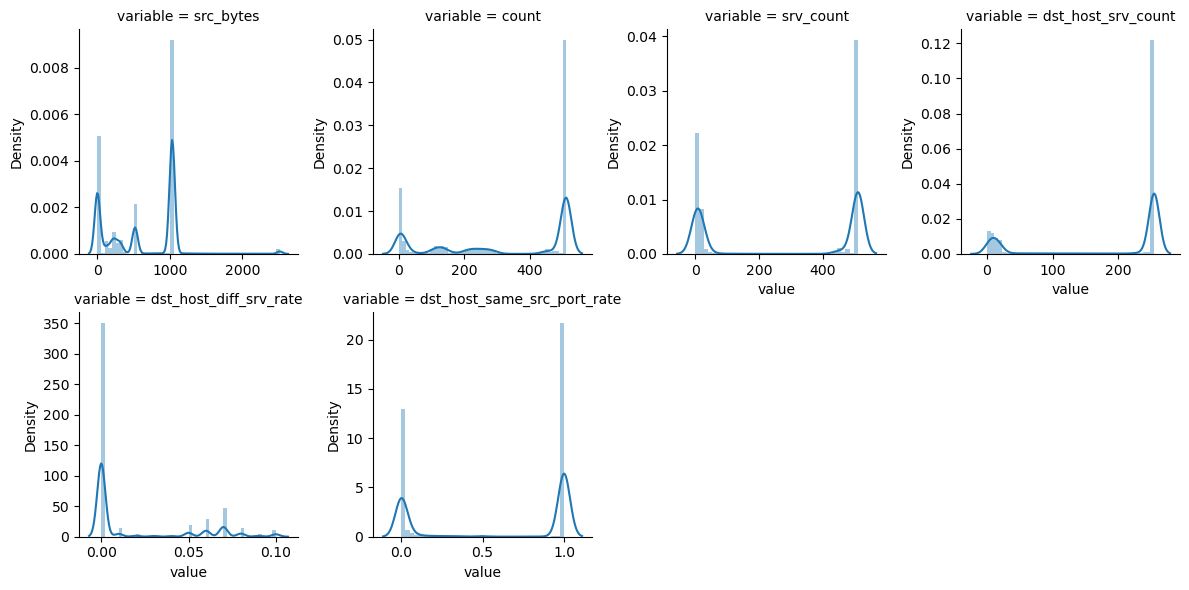

In [74]:
f4=pd.melt(X_train,value_vars=conti_vars)
graph=sns.FacetGrid(f4,col='variable',col_wrap=4,sharex=False,sharey=False)
graph.map(sns.distplot,'value')

Có thể thấy dữ liệu có các trường với scale khá lệch nhau,vd như các trường protocol_type,service,flag có giá trị trong các trường đấy giao động từ 0->1 trong khi trường src_bytes hay srv_counts có giá trị giao động từ phần trăm đến phần nghìn,không những vậy phân phối của các continuous variables k fit với 1 phân phối chuẩn mà bị sai lệch hay có thể thấy được ta ra nhờ mix 2 hay nhiều phân phối chuẩn khác nhau.Từ 2 lý do trên,ta sử dụng Min-Max scaler để normalize dữ liệu

In [88]:
from sklearn.preprocessing import MinMaxScaler
mms=MinMaxScaler()
X_train[conti_vars+disc_vars]=mms.fit_transform(X_train[conti_vars+disc_vars])
X_test[conti_vars+disc_vars]=mms.transform(X_test[conti_vars+disc_vars])


In [89]:
X_train

,protocol_type,service,flag,src_bytes,logged_in,root_shell,su_attempted,is_guest_login,count,srv_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,label_transform
133888,0.004439,0.002657,0.223207,0.410501,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.00,0
67704,0.404179,0.102271,0.001055,0.000000,0.0,0.0,0.0,0.0,0.430528,0.019569,0.039216,0.7,0.00,0
391027,0.404179,0.102271,0.001055,0.000000,0.0,0.0,0.0,0.0,0.577299,0.046967,0.094118,0.5,0.00,0
372089,0.404179,0.825340,0.197679,0.000000,0.0,0.0,0.0,0.0,0.001957,0.001957,0.031373,0.0,0.12,1
460597,0.404179,0.102271,0.197679,0.000000,0.0,0.0,0.0,0.0,0.217221,0.013699,0.027451,0.7,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,0.004439,0.002657,0.223207,0.410501,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.00,0
365838,0.404179,0.102271,0.001055,0.000000,0.0,0.0,0.0,0.0,0.205479,0.009785,0.031373,0.6,0.00,0
131932,0.004439,0.002657,0.223207,0.410501,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.00,0
146867,0.941389,0.483008,0.223207,0.058473,0.0,0.0,0.0,0.0,0.001957,0.001957,0.011765,1.0,0.84,1


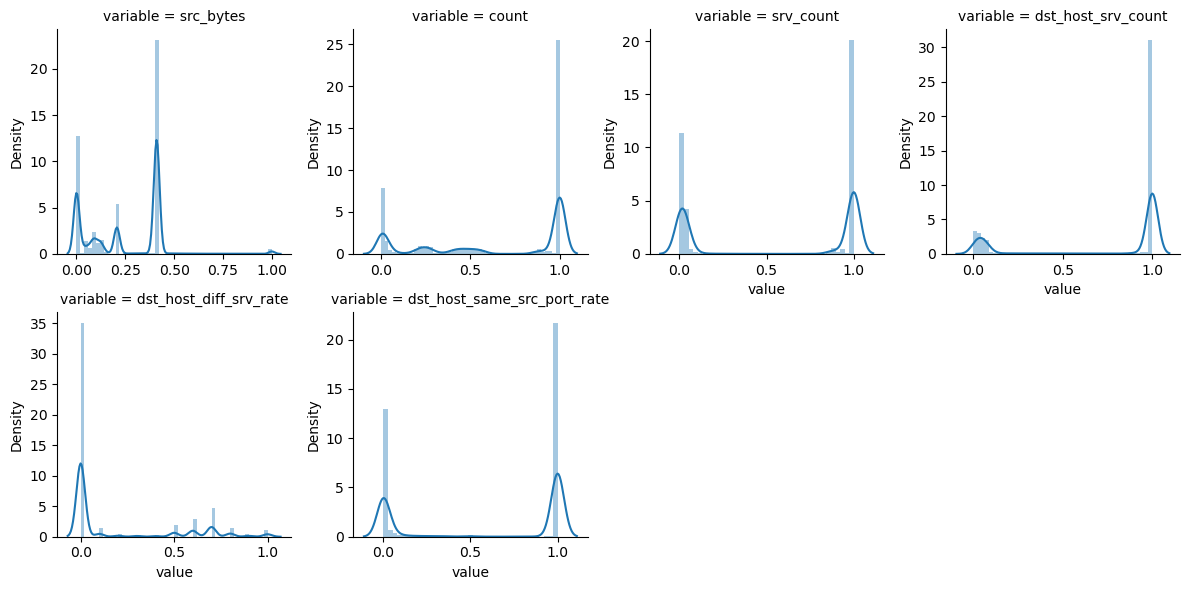

In [77]:
f5=pd.melt(X_train,value_vars=conti_vars)
graph=sns.FacetGrid(f5,col='variable',col_wrap=4,sharex=False,sharey=False)
graph.map(sns.distplot,'value')

In [90]:
X_train.drop('label_transform',axis=1,inplace=True)

In [91]:
X_train

,protocol_type,service,flag,src_bytes,logged_in,root_shell,su_attempted,is_guest_login,count,srv_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate
133888,0.004439,0.002657,0.223207,0.410501,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.00
67704,0.404179,0.102271,0.001055,0.000000,0.0,0.0,0.0,0.0,0.430528,0.019569,0.039216,0.7,0.00
391027,0.404179,0.102271,0.001055,0.000000,0.0,0.0,0.0,0.0,0.577299,0.046967,0.094118,0.5,0.00
372089,0.404179,0.825340,0.197679,0.000000,0.0,0.0,0.0,0.0,0.001957,0.001957,0.031373,0.0,0.12
460597,0.404179,0.102271,0.197679,0.000000,0.0,0.0,0.0,0.0,0.217221,0.013699,0.027451,0.7,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,0.004439,0.002657,0.223207,0.410501,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.00
365838,0.404179,0.102271,0.001055,0.000000,0.0,0.0,0.0,0.0,0.205479,0.009785,0.031373,0.6,0.00
131932,0.004439,0.002657,0.223207,0.410501,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.00
146867,0.941389,0.483008,0.223207,0.058473,0.0,0.0,0.0,0.0,0.001957,0.001957,0.011765,1.0,0.84


In [92]:
#Encode lại trường output
y_train=y_train.map({'normal':0,'dos':1,'other':2})
y_test=y_test.map({'normal':0,'dos':1,'other':2})

4.Modeling

4.1 Random Forest

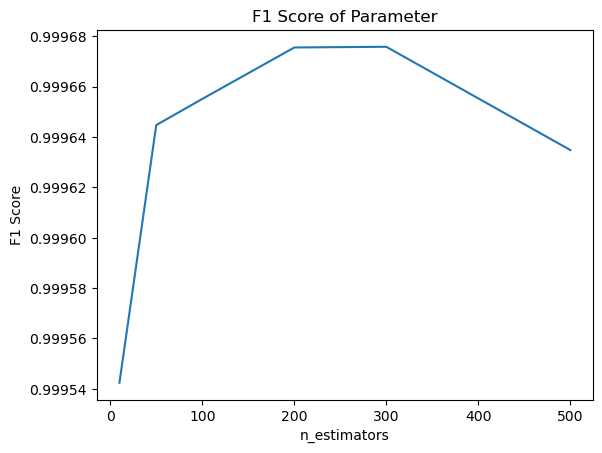

In [38]:
n_estimator= [10,50,100,200,300,500]     # Number of trees in the forest      
F1score = []
for i in n_estimator:
        rfc=RandomForestClassifier(n_estimators=i)
        rfc.fit(X_train,y_train)
        test_pred=rfc.predict(X_test)
        F1score.append(f1_score(y_test,test_pred,average='weighted'))
plt.plot(n_estimator,F1score)
plt.xticks(rotation =0)
plt.xlabel('n_estimators')
plt.ylabel('F1 Score')
plt.title('F1 Score of Parameter')
plt.show()

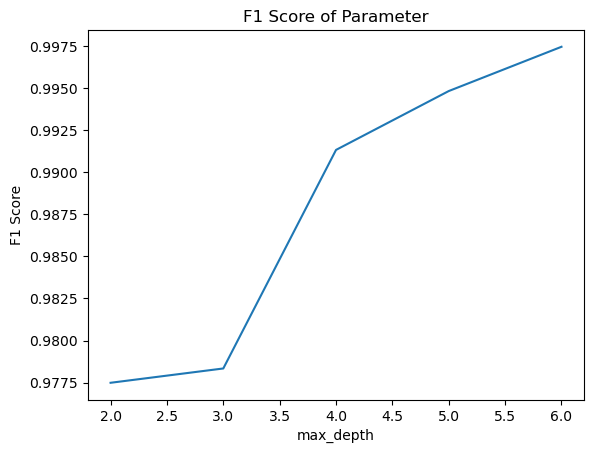

In [39]:
max_depth= [2,3,4,5,6]     # Number of trees in the forest      
f1score = []
for i in max_depth:
        rfc=RandomForestClassifier(n_estimators=300,max_depth=i)
        rfc.fit(X_train,y_train)
        test_pred=rfc.predict(X_test)
        f1score.append(f1_score(y_test,test_pred,average='weighted'))
plt.plot(max_depth,f1score)
plt.xticks(rotation =0)
plt.xlabel('max_depth')
plt.ylabel('F1 Score')
plt.title('F1 Score of Parameter')
plt.show()

In [40]:
rfc=RandomForestClassifier(n_estimators=300,max_depth=6)
rfc.fit(X_train,y_train)
test_pred_rfc=rfc.predict(X_test)

In [41]:
accuracy_rfc=accuracy_score(y_test,test_pred_rfc)

In [42]:
print(classification_report(y_test,test_pred_rfc))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19353
           1       1.00      1.00      1.00     78355
           2       0.99      0.87      0.93      1097

    accuracy                           1.00     98805
   macro avg       0.99      0.96      0.97     98805
weighted avg       1.00      1.00      1.00     98805



4.2 Support Vector Machine (SVM) 

In [ ]:
f1score = []
kernel_tune = ['rbf','linear','sigmoid']
for i in kernel_tune:
    svm_model = SVC(kernel=i)
    svm_model.fit(X_train, y_train)
    test_pred_svm = svm_model.predict(X_test)
    f1score.append(f1_score(y_test, test_pred_svm,average='weighted'))
plt.plot(kernel_tune,f1score)
plt.xticks(rotation = 0)
plt.xlabel('Kernel')
plt.ylabel('F1_Score')
plt.title('F1_score of Kernels')
plt.show()

In [ ]:
f1score = []
C_parameter = [0.001,0.01,0.1,1,10,100]
for i in kernel_tune:
    svm_model = SVC(kernel='rbf',C=i)
    svm_model.fit(X_train, y_train)
    test_pred_svm = svm_model.predict(X_test)
    f1score.append(f1_score(y_test, test_pred_svm,average='weighted'))
plt.plot(C_parameter,f1score)
plt.xticks(rotation = 0)
plt.xlabel('Paramter C')
plt.ylabel('f1_score ')
plt.title('F1_score of C')
plt.show()

In [ ]:
f1score = []
gamma_parameter = [0.01,0.1,1,10,100,1000,'scale']
for i in kernel_tune:
    svm_model = SVC(kernel='rbf',C=10,gamma=i)
    svm_model.fit(X_train, y_train)
    test_pred_svm = svm_model.predict(X_test)
    f1score.append(f1_score(y_test, test_pred_svm,average='weighted'))
plt.plot(gamma_parameter,f1score)
plt.xticks(rotation = 0)
plt.xlabel('Paramter Gamma')
plt.ylabel('f1_score ')
plt.title('F1_score of Gamma')
plt.show()

In [ ]:
svc=SVC(kernel='rbf',C=10,gamma=100)
svc.fit(X_train,y_train)
test_pred_svm=svc.predict(X_test)


In [ ]:
accuracy_svm=accuracy_score(y_test,test_pred_svm)

In [ ]:
print(classification_report(y_test,test_pred_svm))

4.3 Gaussian Naive Bayes

In [106]:
gnb=GaussianNB()
gnb.fit(X_train,y_train)
test_pred_gnb=gnb.predict(X_test)

In [107]:
accuracy_gnb=accuracy_score(y_test,test_pred_gnb)

In [108]:
print(classification_report(y_test,test_pred_gnb))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93     19353
           1       0.97      0.99      0.98     78355
           2       0.29      0.07      0.12      1097

    accuracy                           0.97     98805
   macro avg       0.74      0.66      0.68     98805
weighted avg       0.96      0.97      0.96     98805



4.4 Multinomial Naive Bayes

In [96]:
mnb=MultinomialNB()
mnb.fit(X_train,y_train)
test_pred_mnb=mnb.predict(X_test)

In [97]:
accuracy_mnb=accuracy_score(y_test,test_pred_mnb)

In [98]:
print(classification_report(y_test,test_pred_mnb))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     19353
           1       0.98      0.99      0.98     78355
           2       0.21      0.00      0.01      1097

    accuracy                           0.97     98805
   macro avg       0.71      0.65      0.65     98805
weighted avg       0.96      0.97      0.97     98805



4.5 Gaussian Mixture

In [99]:
gm=GaussianMixture(n_components=3,random_state=23)
gm.fit(X_train,y_train)
test_pred_gm=gm.predict(X_test)

In [101]:
accuracy_gm=accuracy_score(y_test,test_pred_gm)

In [102]:
print(classification_report(y_test,test_pred_gm))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     19353
           1       0.88      0.27      0.41     78355
           2       0.04      0.73      0.08      1097

    accuracy                           0.22     98805
   macro avg       0.31      0.33      0.17     98805
weighted avg       0.70      0.22      0.33     98805



4.6 Bernoulli Naive Bayes

In [109]:
bnb=BernoulliNB()
bnb.fit(X_train,y_train)
test_pred_bnb=bnb.predict(X_test)

In [110]:
accuracy_bnb=accuracy_score(y_test,test_pred_bnb)

In [111]:
print(classification_report(y_test,test_pred_bnb))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82     19353
           1       0.92      0.99      0.96     78355
           2       0.95      0.02      0.04      1097

    accuracy                           0.93     98805
   macro avg       0.94      0.58      0.60     98805
weighted avg       0.93      0.93      0.92     98805



4.7 Logistic Regression

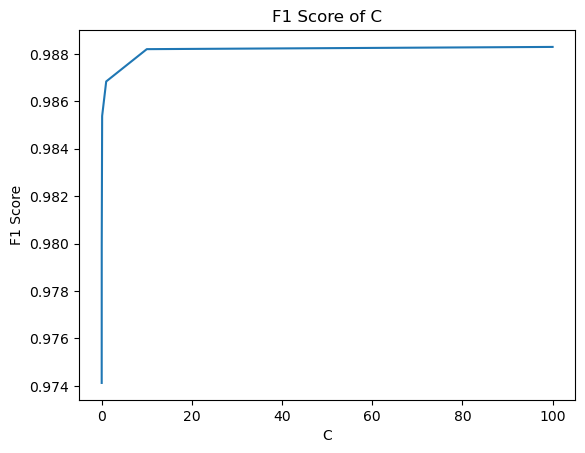

In [150]:
f1_scores = []
C_values = [0.001,0.01, 0.1, 1, 10,100]
for C in C_values:
    lr_model = LogisticRegression(C=C)
    lr_model.fit(X_train, y_train)
    test_pred_lr = lr_model.predict(X_test)
    f1_scores.append(f1_score(y_test, test_pred_lr, average='weighted'))
plt.plot(C_values, f1_scores)

plt.xticks(rotation=0)

plt.xlabel('C')

plt.ylabel('F1 Score')

plt.title('F1 Score of C')

plt.show()

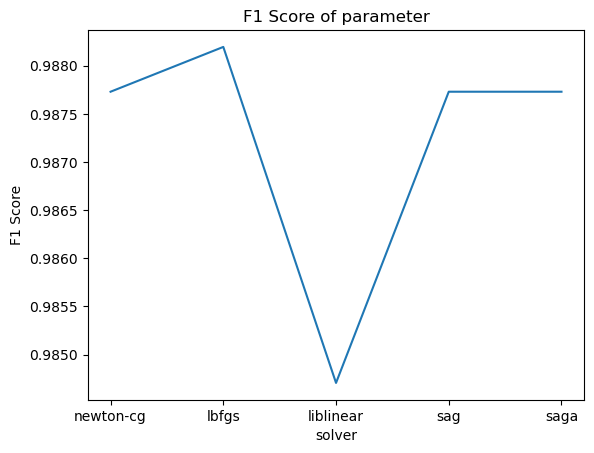

In [57]:
sol=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
f1_scores = []
for i in sol:
    lr_model = LogisticRegression(C=10,solver=i,random_state=23)
    lr_model.fit(X_train,y_train)
    test_pred_lr = lr_model.predict(X_test)
    f1_scores.append(f1_score(y_test,test_pred_lr, average='weighted'))
plt.plot(sol, f1_scores)
plt.xticks(rotation=0)
plt.xlabel('solver')
plt.ylabel('F1 Score')
plt.title('F1 Score of parameter')
plt.show()

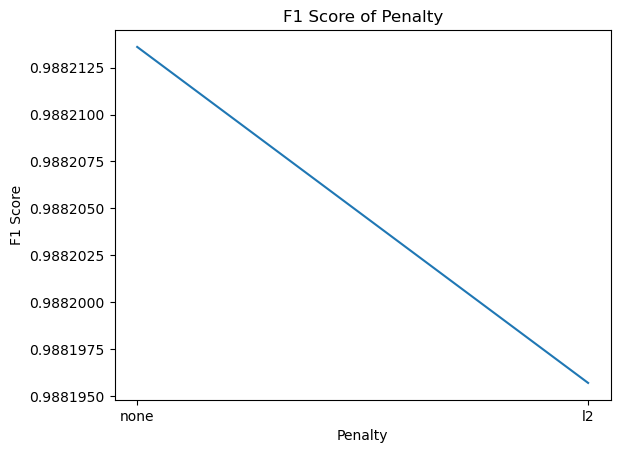

In [59]:
penalties = ['none','l2']
f1_scores = []
for pen in penalties:
    lr_model = LogisticRegression(C=10,solver='lbfgs',penalty=pen,random_state=23)
    lr_model.fit(X_train,y_train)
    test_pred_lr = lr_model.predict(X_test)
    f1_scores.append(f1_score(y_test,test_pred_lr, average='weighted'))
plt.plot(penalties, f1_scores)
plt.xticks(rotation=0)
plt.xlabel('Penalty')
plt.ylabel('F1 Score')
plt.title('F1 Score of Penalty')
plt.show()

In [71]:
lr=LogisticRegression(C=10,solver='lbfgs',penalty='none',random_state=23)
lr.fit(X_train,y_train)
test_pred_lr=lr.predict(X_test)

In [72]:
accuracy_lr=accuracy_score(y_test,test_pred_lr)

In [73]:
print(classification_report(y_test,test_pred_lr))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     19353
           1       1.00      1.00      1.00     78355
           2       0.76      0.65      0.70      1097

    accuracy                           0.99     98805
   macro avg       0.91      0.88      0.89     98805
weighted avg       0.99      0.99      0.99     98805



4.8 XGBoost

In [112]:
xgb=XGBClassifier()
xgb.fit(X_train,y_train)
test_pred_xgb=xgb.predict(X_test)

In [113]:
accuracy_xgb=accuracy_score(y_test,test_pred_xgb)

In [114]:
print(classification_report(y_test,test_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19353
           1       1.00      1.00      1.00     78355
           2       0.99      0.99      0.99      1097

    accuracy                           1.00     98805
   macro avg       1.00      0.99      1.00     98805
weighted avg       1.00      1.00      1.00     98805



5.Comparision performance of Models

In [ ]:
model=['Random Forest','SVM','Gaussian NB','Multinomial NB','Gaussian Mixture','Bernoulli NB','Logistic Regression','XGBoost']
accuracy=list((accuracy_rfc,accuracy_svm,accuracy_gnb,accuracy_mnb,accuracy_gm,accuracy_bnb,accuracy_lr,accuracy_xgb))
plt.bar(model,accuracy)
plt.title('Perfomance of Models')
plt.ylabel('accuracy')
plt.xlabel('model')
plt.xticks(rotation=90)
plt.show()

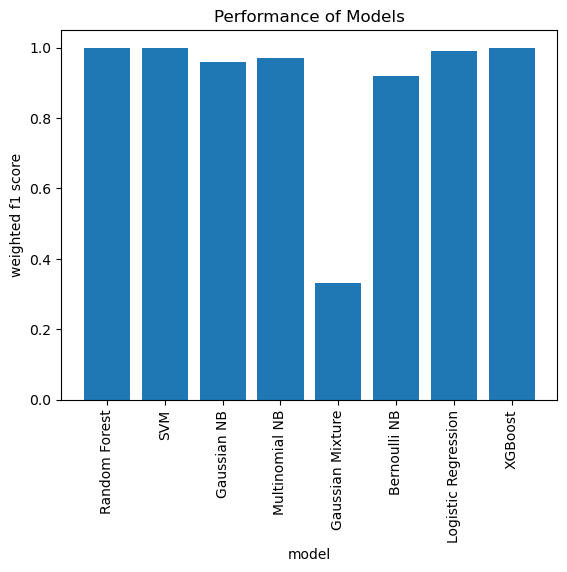

In [119]:
f1=[1.0,1.0,0.96,0.97,0.33,0.92,0.99,1.0]
plt.bar(model,f1)
plt.title('Performance of Models')
plt.ylabel('weighted f1 score')
plt.xlabel('model')
plt.xticks(rotation=90)
plt.show()